In [15]:
import pandas as pd
from pathlib import Path
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt
import geopandas as gpd
import numpy as np
import osmnx as ox
from shapely.geometry import Polygon
from IPython.display import display
import ipywidgets as widgets
from ipywidgets import interact
import warnings
from scipy.spatial.distance import cdist

warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [3]:
# Load the dataframe outside the function
data_dir = Path("/data/pgcasado/datasets/acute/")
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=FutureWarning)
    df = pd.concat(
        pd.read_parquet(parquet_file)
        for parquet_file in data_dir.glob('*.parquet')
    )

mask = (df['timestamp'] > '2023-06-21') & (df['timestamp'] <= '2023-12-31') & (df["station_name"] == "0QRDKC2R03J32P")
df = df[mask] # Create a copy to avoid SettingWithCopyWarning

def plot_clusters(altitude_limit, eps, min_samples, selected_tags):
    
    global df  # Use the global df inside the function
    
    # Filter by altitude
    mask_alt = (df["altitude"] > altitude_limit)
    df_filtered_mask = df.loc[mask_alt].copy()
    
    # Define your latitude and longitude limits
    lat_min, lat_max = df_filtered_mask["latitude"].min(), df_filtered_mask["latitude"].max()
    lon_min, lon_max = df_filtered_mask["longitude"].min(), df_filtered_mask["longitude"].max()

    # Create a square polygon
    polygon = Polygon([(lon_min, lat_min), (lon_min, lat_max), (lon_max, lat_max), (lon_max, lat_min)])

    # Create the dataframe of the place of interest
    #tags = {"building": ["church", "palace", "chapel", "university", "hospital", "government", "stadium", "historic"], "amenities"}
     # Convert selected_tags to a dictionary
    tags = {tag.split(": ")[0]: [tag.split(": ")[1]] for tag in selected_tags}
    dfx = ox.features.features_from_polygon(polygon, tags= tags).copy()  # Create a copy to avoid SettingWithCopyWarning
    dfx.dropna(subset=['name'], inplace=True)
    dfx['longitude'] = dfx['geometry'].apply(lambda x: x.centroid.coords.xy[0][0])
    dfx['latitude'] = dfx['geometry'].apply(lambda x: x.centroid.coords.xy[1][0])

    # Read the shapefile for the world map
    warnings.filterwarnings("ignore")
    world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

    # Plot the world map
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=FutureWarning)
        world.plot(color='white', edgecolor='black')

    # Create a DBSCAN object with the updated parameters
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)

    # Fit the model to the data
    dbscan.fit(df_filtered_mask[['latitude', 'longitude']])
    df_filtered_mask["cluster"] = dbscan.labels_

    dfn = df_filtered_mask[df_filtered_mask["cluster"] >= 0]
    labels = np.delete(dbscan.labels_, np.where(dbscan.labels_ == -1))

    # Plot the clusters
    plt.scatter(dfn['longitude'], dfn['latitude'], c=labels, cmap="tab10", marker=".")

    # Add the cluster labels to the plot
    for i in range(len(np.unique(labels))):
        x = np.mean(dfn[dfn["cluster"] == i]['longitude'])
        y = np.mean(dfn[dfn["cluster"] == i]['latitude'])
        plt.annotate(str(i), xy=(x, y), color='black', fontsize=12, fontweight='bold', ha='center', va='center')

    # Set the x and y limits of the plot
    plt.xlabel("longitude")
    plt.ylabel("latitude")
    plt.xlim(dfn["longitude"].min()-0.01, dfn["longitude"].max()+0.01)
    plt.ylim(dfn["latitude"].min()-0.01, dfn["latitude"].max()+0.01)

    plt.scatter(df_filtered_mask["station_longitude"].iloc[0], df_filtered_mask["station_latitude"].iloc[0], marker="+", color="black")
    plt.scatter(dfx["longitude"].values, dfx["latitude"].values, marker=".", color="black", s = 2)

    # Show the plot
    plt.show()
    
    cluster_df = pd.DataFrame()
    for i in range(df_filtered_mask["cluster"].max()):
        df_i = df_filtered_mask[df_filtered_mask["cluster"]==i]
        cluster_df.loc[i, "max_altitude"] = df_i["altitude"].max()
        cluster_df.loc[i, ">100"] = sum(df_i["altitude"] > 100)
        #cluster_df.loc[i, "max_distance"] = df_i["distance"].max()

    cluster_df[">100"] = cluster_df[">100"].astype("int")
    display(cluster_df)

# Use interact to create interactive sliders
# Use interact to create interactive sliders
interact(
    plot_clusters,
    altitude_limit=widgets.FloatSlider(min=0, max=500, step=10, value=100, description='Altitude Limit'),
    eps=widgets.FloatSlider(min=0.001, max=0.2, step=0.001, value=0.025, description='Eps'),
    min_samples=widgets.IntSlider(min=1, max=50, step=1, value=17, description='Min Samples'),
    selected_tags=widgets.SelectMultiple(options=["building: church", "building: chapel", "building: university", "building: hospital", "building: government", "building: stadium", "amenities: prison", "amenities: police"],
                                         value=["building: university",], description='Tags')
)


interactive(children=(FloatSlider(value=100.0, description='Altitude Limit', max=500.0, step=10.0), FloatSlide…

<function __main__.plot_clusters(altitude_limit, eps, min_samples, selected_tags)>

(6, 2)


/tmp/ipykernel_910024/3949101552.py:37: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


(50.56199478149414, 51.336549530029295)

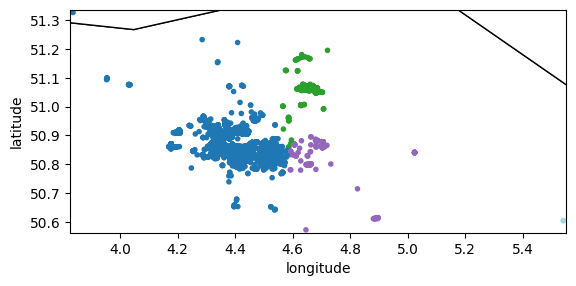

In [96]:
def haversine(lonlat1, lonlat2):
    lon1, lat1 = lonlat1
    lon2, lat2 = lonlat2
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2

    c = 2 * np.arcsin(np.sqrt(a))
    km = 6367 * c
    return km



altitude_limit = 150
mask_alt = (df["altitude"] > altitude_limit)
df = df.loc[mask_alt]

# Define your latitude and longitude limits
lat_min, lat_max = df["latitude"].min(), df["latitude"].max()
lon_min, lon_max = df["longitude"].min(), df["longitude"].max()

# Create a square polygon
polygon = Polygon([(lon_min, lat_min), (lon_min, lat_max), (lon_max, lat_max), (lon_max, lat_min)])

# Create the dataframe of the place of interest
#tags = {"building": ["church", "palace", "chapel", "university", "hospital", "government", "stadium", "historic"]}
tags = {"building":"stadium"}
dfx = ox.features.features_from_polygon(polygon, tags=tags)
dfx.dropna(subset=['name'], inplace=True)
dfx['longitude'] = dfx['geometry'].apply(lambda x: x.centroid.coords.xy[0][0])
dfx['latitude']  = dfx['geometry'].apply(lambda x: x.centroid.coords.xy[1][0])

# read the shapefile for the world map
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# plot the world map
world.plot(color='white', edgecolor='black')

# Calculate the distance between each point and each centroid
centroids = dfx[["latitude", "longitude"]].to_numpy()
points = df[["latitude", "longitude"]].to_numpy()
distances = cdist(points, centroids, "euclidean")
print(centroids.shape)
# Find the index of the closest centroid for each point
clusters = np.argmin(distances, axis=1)

# plot the clusters
plt.scatter(df['longitude'], df['latitude'], c=clusters, cmap = "tab20", marker=".")

# set the x and y limits of the plot
plt.xlabel("longitude")
plt.ylabel("latitude")
plt.xlim(df["longitude"].min()-0.01, df["longitude"].max()+0.01)
plt.ylim(df["latitude"].min()-0.01, df["latitude"].max()+0.01)


In [90]:
# Assuming df is your DataFrame
dictionary = dfx.droplevel(level=1)["name"].reset_index().set_index("name").squeeze().to_dict()
sorted_dict = dict(sorted(dictionary.items()))

In [92]:
for a, b in sorted_dict.items():
    if len(a) > 2:
        print(a, b)

200A - Computerwetenschappen way
200B - Instituut voor Wiskunde way
200C - Kandidatuur Natuurkunde way
200D - Instituut Natuurkunde navorsing relation
200E - Geo-instituut way
200F - Chem&Tech way
200G - Kandidatuur Scheikunde way
200H - Quadrivium way
200I - Monitoraten way
Administratief en Logistiek gebouw relation
Afvalgebouw way
Amfitheater relation
Antwerp Management School node
Arenbergkasteel way
Arlon 14 way
Atelier de dessin way
Auditoire André Simonart way
Auditoire Paul-Emile Janson way
Auditoires Agora way
Auditoires Croix du Sud way
Auditoires Montesquieu way
Auditoires Pierre de Coubertin way
Auditoires centraux way
Auditoires des Sciences way
Auditoria 200K way
Auditoria 200L way
Auditoria 200M way
Auditoria 200N way
Auditoria J.Monnet-M.Weber way
Auditoriacomplex way
Auditorium Bouckaert way
Auditorium Oude Molen way
Bergplaats way
Bergplaats Alma way
Bibliothèque des Sciences et Technologies way
Bio-incubator 1 way
Biomed 2 way
Biosystemen I way
Bodemkundige Dienst va

In [13]:
df[["latitude", "longitude"]].to_numpy()

array([[50.85164 ,  4.434183],
       [50.851643,  4.434183],
       [50.851643,  4.434183],
       ...,
       [51.058594,  4.678773],
       [51.054104,  4.677547],
       [50.83507 ,  4.515033]], dtype=float32)